In [1]:
import torch
from torch import autograd, nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
training_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform = torchvision.transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(training_data, batch_size=256,
                                          shuffle=True, num_workers=2)

test_data = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform = torchvision.transforms.ToTensor())
testloader = torch.utils.data.DataLoader(test_data, batch_size=4,
                                         shuffle=False, num_workers=2)

# ordered class labels by idx
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


50000 training examples, 10000 test examples


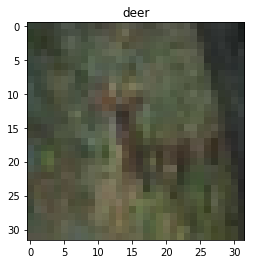

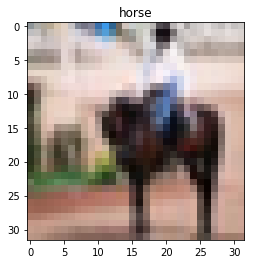

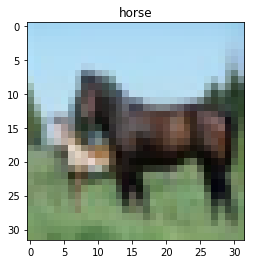

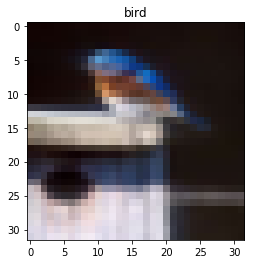

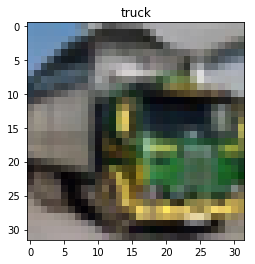

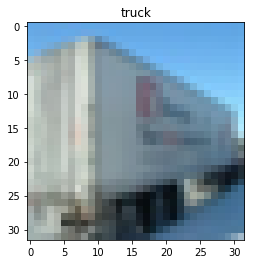

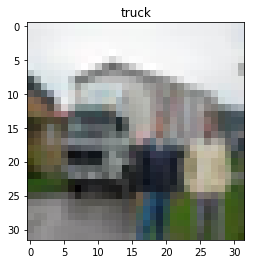

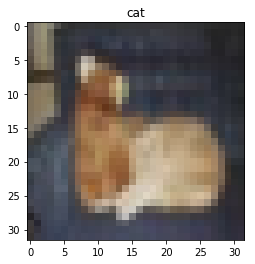

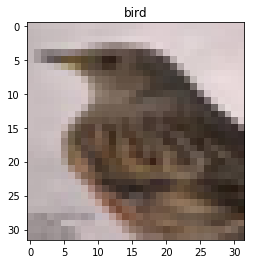

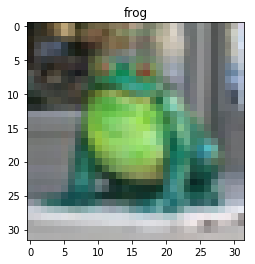

In [3]:
def plot_images(image_label_pairs):
    """Plot a list of images
    :param image_label_pairs: list of (image, label) pairs given by the dataset
    """
    for image, label in image_label_pairs:
        npimg = image.numpy()
        plt.figure()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.title(classes[label])
        plt.show()
    
n_train, n_test = len(training_data), len(test_data)
print("{} training examples, {} test examples".format(n_train, n_test))
# plot a few sample images
n = [training_data[i] for i in range(10, 20)]
plot_images(n)

In [5]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size = 3, stride = 1)
        # response norm here
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2) # results in overlapping pooling
        self.conv2 = nn.Conv2d(96, 256, kernel_size = 3)
        # response norm here
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2) # results in overlapping pooling
#         self.conv3 = nn.Conv2d(256, 384, kernel_size = 2)
#         self.conv4 = nn.Conv2d(384, 384, kernel_size = 2)
#         self.conv5 = nn.Conv2d(384, 256, kernel_size = 2)
#         self.pool5 = nn.MaxPool2d(kernel_size = 1, stride = 1)
        # 2 fully connected layers followed by a softmax
        self.linear1 = nn.Linear(9216, 2048)
        self.linear2 = nn.Linear(2048, 2048)
        self.out_layer = nn.Linear(2048, len(classes))
    
    def forward(self, x):
        # first layer transformation: conv -> relu -> pool
        x = self.pool1(F.relu(self.conv1(x)))
        # second layer transformation: conv -> relu -> pool
        x = self.pool2(F.relu(self.conv2(x)))
        # third, 4th layer transformation: conv -> relu
#         x = F.relu(self.conv3(x))
#         x = F.relu(self.conv4(x))
#         # 5th layer: conv -> relu -> pool
#         x = F.relu(self.conv5(x))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.linear1(x))
        # drop
        x = F.dropout(x)
        x = F.relu(self.linear2(x))
        # drop
        x = F.dropout(x)
        x = F.relu(self.out_layer(x))
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    

In [6]:
# initialize the network
alex_net = AlexNet()
alex_net

AlexNet(
  (conv1): Conv2d (3, 96, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d (96, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (linear1): Linear(in_features=9216, out_features=2048)
  (linear2): Linear(in_features=2048, out_features=2048)
  (out_layer): Linear(in_features=2048, out_features=10)
)

In [ ]:
# define the loss and optimization function
loss = nn.CrossEntropyLoss()
opt = optim.SGD(alex_net.parameters(), lr = 0.01, momentum = 0.9) # TODO figure out how to reduce learning rate
dataiter = iter(trainloader)
print(n_train)
losses = []
for epoch in range(5000):
    opt.zero_grad()
    try:
        batch = next(dataiter)
    except StopIteration:
        dataiter = iter(trainloader)
        batch = next(dataiter)
    image_batch, label_batch = batch
    image_batch = autograd.Variable(image_batch)
    label_batch = autograd.Variable(label_batch)
    out_batch = alex_net.forward(image_batch)
    cur_loss = loss(out_batch, label_batch)
    cur_loss.backward()
    opt.step()
    losses.append(cur_loss)
    if epoch % 50 == 0:
        print("epoch: {}, loss: {}".format(epoch, cur_loss.data[0]))

print('done training! final loss: {}'.format(cur_loss.data[0]))

        

50000
epoch: 0, loss: 2.3024046421051025
epoch: 50, loss: 2.2810544967651367
epoch: 100, loss: 2.224966526031494
